Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


Set Random Seeds

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Downloading the dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amerzishminha/forest-fire-smoke-and-non-fire-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 6.43G/6.43G [01:10<00:00, 97.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3


Load Dataset (KaggleHub Path)

In [ ]:
DATASET_PATH = "/root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3"

print("Dataset root path:", DATASET_PATH)
print("Contents:", os.listdir(DATASET_PATH))


Dataset root path: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3
Contents: ['FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET']


Auto-detect DATA_DIR (Folder containing Fire/Smoke/Non-Fire)

In [ ]:
DATA_DIR = None

for root, dirs, files in os.walk(DATASET_PATH):
    lower_dirs = [d.lower() for d in dirs]
    if "fire" in lower_dirs and "smoke" in lower_dirs:
        DATA_DIR = root
        break

print("Detected DATA_DIR:", DATA_DIR)
print("Classes found:", os.listdir(DATA_DIR))


Detected DATA_DIR: /root/.cache/kagglehub/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset/versions/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train
Classes found: ['Smoke', 'non fire', 'fire']


Load Image Filepaths into DataFrame

In [ ]:
image_paths = []
labels = []

for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)

    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(class_path, file))
                labels.append(class_name)

df = pd.DataFrame({"filepath": image_paths, "label": labels})

print("Total images:", len(df))
df.head()


Total images: 31706


,filepath,label
0,/root/.cache/kagglehub/datasets/amerzishminha/...,Smoke
1,/root/.cache/kagglehub/datasets/amerzishminha/...,Smoke
2,/root/.cache/kagglehub/datasets/amerzishminha/...,Smoke
3,/root/.cache/kagglehub/datasets/amerzishminha/...,Smoke
4,/root/.cache/kagglehub/datasets/amerzishminha/...,Smoke


Data Exploration — Class Distribution

label
non fire    10800
fire        10798
Smoke       10108
Name: count, dtype: int64


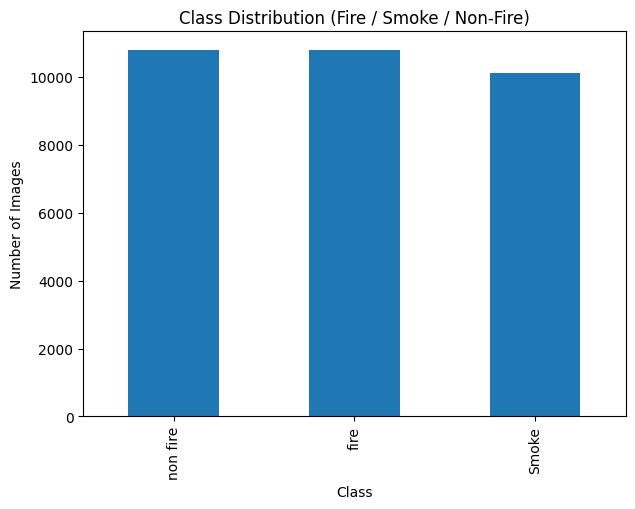

In [ ]:
class_counts = df["label"].value_counts()
print(class_counts)

plt.figure(figsize=(7,5))
class_counts.plot(kind="bar")
plt.title("Class Distribution (Fire / Smoke / Non-Fire)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


Data Exploration — Show Sample Images

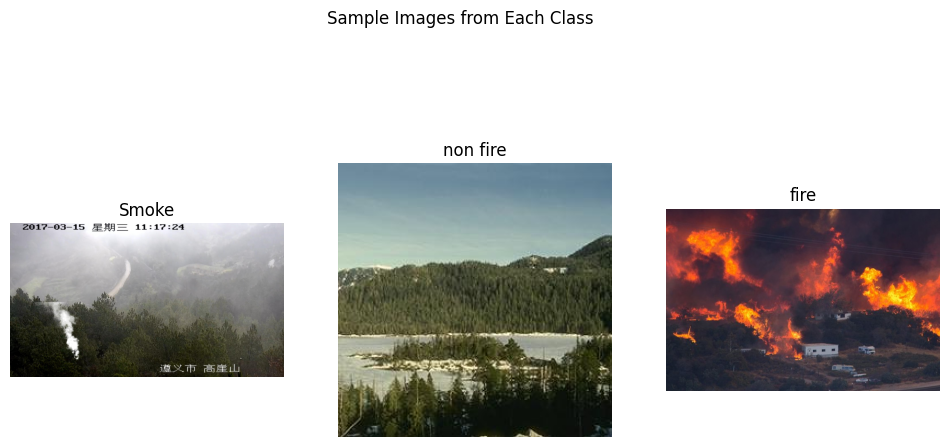

In [ ]:
plt.figure(figsize=(12,6))

for i, class_name in enumerate(df["label"].unique()):
    sample_path = df[df["label"] == class_name].iloc[0]["filepath"]
    img = Image.open(sample_path)

    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()


Data Exploration — Image Size Check

Width range: 250 - 3500
Height range: 145 - 4240


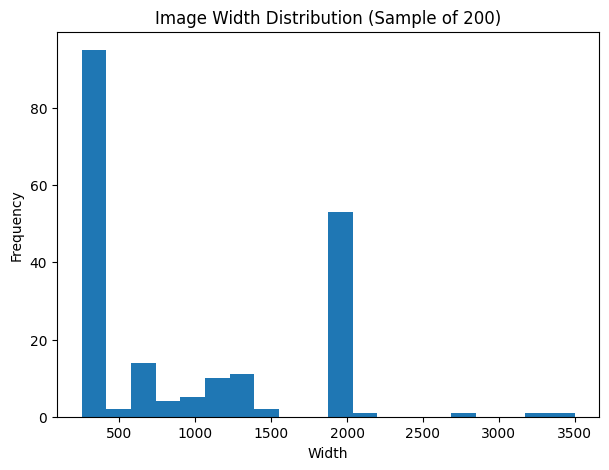

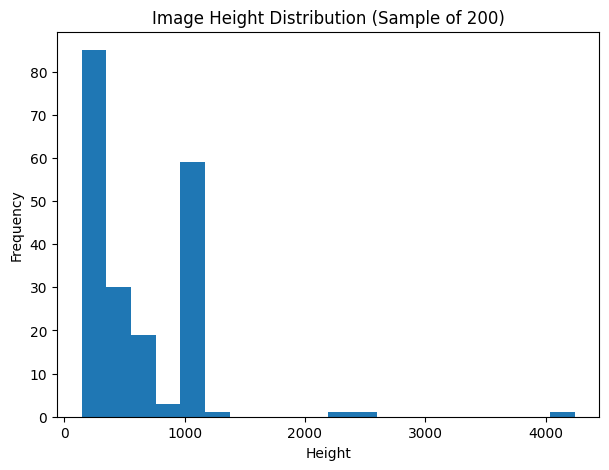

In [ ]:
widths = []
heights = []

sample_df = df.sample(200, random_state=SEED)

for path in sample_df["filepath"]:
    img = Image.open(path)
    w, h = img.size
    widths.append(w)
    heights.append(h)

print("Width range:", min(widths), "-", max(widths))
print("Height range:", min(heights), "-", max(heights))

plt.figure(figsize=(7,5))
plt.hist(widths, bins=20)
plt.title("Image Width Distribution (Sample of 200)")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(7,5))
plt.hist(heights, bins=20)
plt.title("Image Height Distribution (Sample of 200)")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.show()


Split Dataset

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=SEED
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain distribution:\n", train_df["label"].value_counts())
print("\nValidation distribution:\n", val_df["label"].value_counts())
print("\nTest distribution:\n", test_df["label"].value_counts())


Train size: 22194
Validation size: 4756
Test size: 4756

Train distribution:
 label
non fire    7560
fire        7558
Smoke       7076
Name: count, dtype: int64

Validation distribution:
 label
fire        1620
non fire    1620
Smoke       1516
Name: count, dtype: int64

Test distribution:
 label
non fire    1620
fire        1620
Smoke       1516
Name: count, dtype: int64


BASELINE CNN (NO AUGMENTATION)

Data Generators (Baseline)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)
class_labels = list(train_gen.class_indices.keys())

print("Class indices:", train_gen.class_indices)


Found 22194 validated image filenames belonging to 3 classes.
Found 4756 validated image filenames belonging to 3 classes.
Found 4756 validated image filenames belonging to 3 classes.
Class indices: {'Smoke': 0, 'fire': 1, 'non fire': 2}


Build Baseline CNN

In [ ]:
baseline_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

baseline_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Train Baseline CNN

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history_baseline = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 945s 1s/step - accuracy: 0.9902 - loss: 0.0314 - val_accuracy: 0.9718 - val_loss: 0.1249 - learning_rate: 0.0010
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 990s 1s/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9668 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 958s 1s/step - accuracy: 0.9923 - loss: 0.0209 - val_accuracy: 0.9680 - val_loss: 0.1592 - learning_rate: 0.0010
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9911 - loss: 0.0295
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
694/694 ━━━━━━━━━━━━━━━━━━━━ 971s 1s/step - accuracy: 0.9911 - loss: 0.0295 - val_accuracy: 0.9706 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 964s 1s/step - accuracy: 0.9957 - loss: 0.0107 - val_accuracy: 0.9712 - val_loss: 0.1701 - learning_rate: 5.0000e-04
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 954s 1s/step - accuracy: 0.9967 - loss: 0

Plot Baseline Training Curves

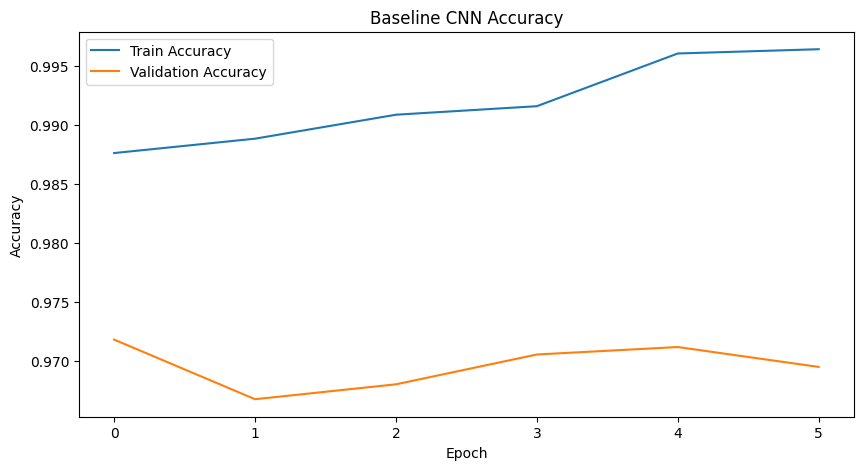

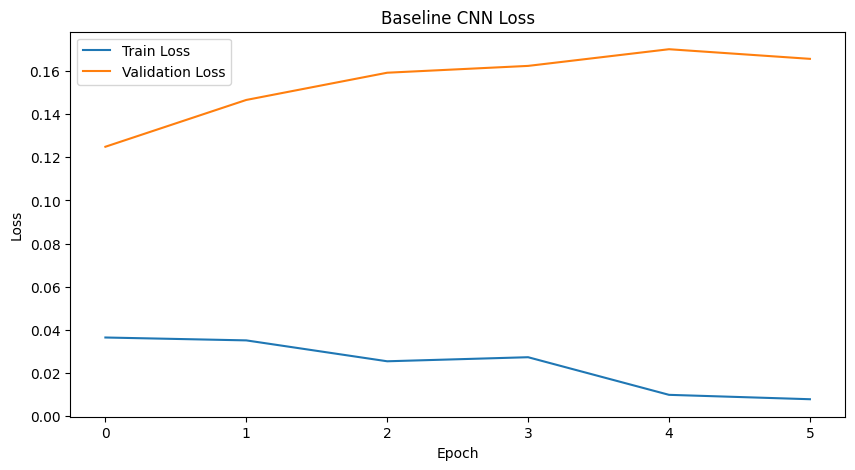

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_baseline.history["accuracy"], label="Train Accuracy")
plt.plot(history_baseline.history["val_accuracy"], label="Validation Accuracy")
plt.title("Baseline CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_baseline.history["loss"], label="Train Loss")
plt.plot(history_baseline.history["val_loss"], label="Validation Loss")
plt.title("Baseline CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Evaluating Baseline Model (Accuracy, Precision, Recall, F1)

In [ ]:
test_gen.reset()

baseline_preds = baseline_model.predict(test_gen)
baseline_pred_classes = np.argmax(baseline_preds, axis=1)
true_classes = test_gen.classes

baseline_acc  = accuracy_score(true_classes, baseline_pred_classes)
baseline_prec = precision_score(true_classes, baseline_pred_classes, average="weighted")
baseline_rec  = recall_score(true_classes, baseline_pred_classes, average="weighted")
baseline_f1   = f1_score(true_classes, baseline_pred_classes, average="weighted")

print("Baseline Test Accuracy:", baseline_acc)
print("Baseline Precision:", baseline_prec)
print("Baseline Recall:", baseline_rec)
print("Baseline F1-score:", baseline_f1)

print("\nClassification Report (Baseline):\n")
print(classification_report(true_classes, baseline_pred_classes, target_names=class_labels))


149/149 ━━━━━━━━━━━━━━━━━━━━ 98s 653ms/step
Baseline Test Accuracy: 0.9703532380151387
Baseline Precision: 0.9704720514179312
Baseline Recall: 0.9703532380151387
Baseline F1-score: 0.9703652236216128

Classification Report (Baseline):

              precision    recall  f1-score   support

       Smoke       0.98      0.97      0.97      1516
        fire       0.96      0.98      0.97      1620
    non fire       0.97      0.97      0.97      1620

    accuracy                           0.97      4756
   macro avg       0.97      0.97      0.97      4756
weighted avg       0.97      0.97      0.97      4756



Confusion Matrix (Baseline)

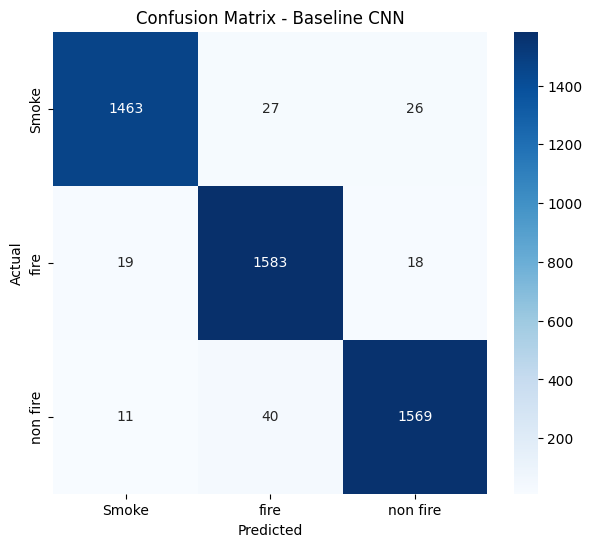

In [ ]:
import seaborn as sns

cm_baseline = confusion_matrix(true_classes, baseline_pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Augmented Training Generator

In [ ]:
aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

aug_train_gen = aug_train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)


Found 22194 validated image filenames belonging to 3 classes.


Build Improved CNN (Dropout + BatchNorm)

In [ ]:
improved_model = models.Sequential([
    layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation="softmax")
])

improved_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

improved_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,779 (32.36 MB)

 Trainable params: 8,483,331 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

Train Improved Model

In [26]:
history_improved = improved_model.fit(
    aug_train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1831s 3s/step - accuracy: 0.8013 - loss: 1.5302 - val_accuracy: 0.8734 - val_loss: 0.4446 - learning_rate: 0.0010
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1861s 3s/step - accuracy: 0.8667 - loss: 0.3906 - val_accuracy: 0.8469 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1817s 3s/step - accuracy: 0.8841 - loss: 0.3447 - val_accuracy: 0.9062 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1854s 3s/step - accuracy: 0.9062 - loss: 0.2907 - val_accuracy: 0.9151 - val_loss: 0.3235 - learning_rate: 0.0010
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1805s 3s/step - accuracy: 0.9117 - loss: 0.2759 - val_accuracy: 0.9256 - val_loss: 0.2782 - learning_rate: 0.0010
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1797s 3s/step - accuracy: 0.9174 - loss: 0.2619 - val_accuracy: 0.9092 - val_loss: 0.3638 - learning_rate: 0.0010
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 1792s 3s/step - accuracy: 0.9241 - l

Plot Improved Training Curves

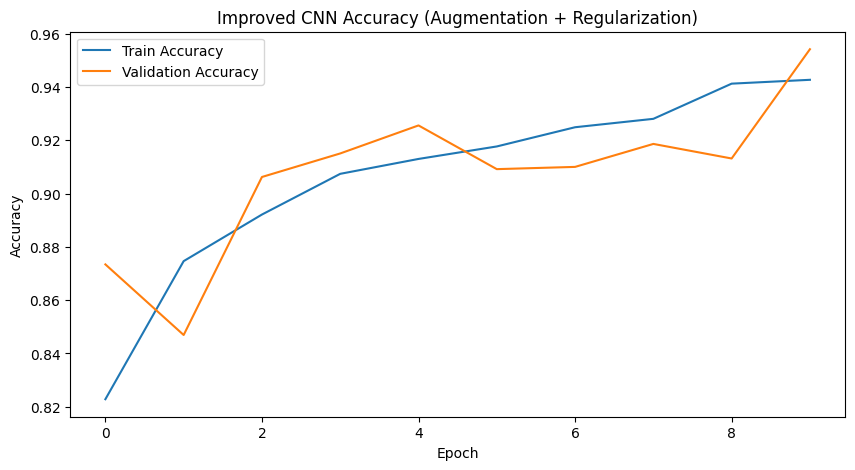

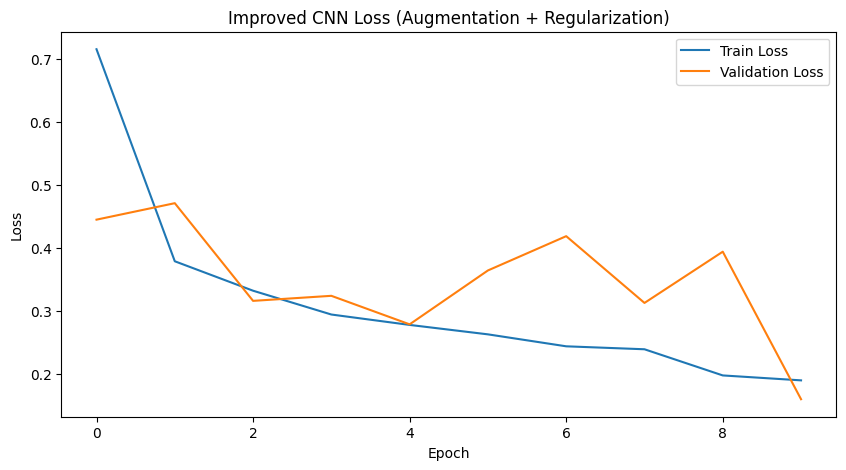

In [27]:
plt.figure(figsize=(10,5))
plt.plot(history_improved.history["accuracy"], label="Train Accuracy")
plt.plot(history_improved.history["val_accuracy"], label="Validation Accuracy")
plt.title("Improved CNN Accuracy (Augmentation + Regularization)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_improved.history["loss"], label="Train Loss")
plt.plot(history_improved.history["val_loss"], label="Validation Loss")
plt.title("Improved CNN Loss (Augmentation + Regularization)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Evaluate Improved Model

In [28]:
test_gen.reset()

improved_preds = improved_model.predict(test_gen)
improved_pred_classes = np.argmax(improved_preds, axis=1)

improved_acc  = accuracy_score(true_classes, improved_pred_classes)
improved_prec = precision_score(true_classes, improved_pred_classes, average="weighted")
improved_rec  = recall_score(true_classes, improved_pred_classes, average="weighted")
improved_f1   = f1_score(true_classes, improved_pred_classes, average="weighted")

print("Improved Test Accuracy:", improved_acc)
print("Improved Precision:", improved_prec)
print("Improved Recall:", improved_rec)
print("Improved F1-score:", improved_f1)

print("\nClassification Report (Improved):\n")
print(classification_report(true_classes, improved_pred_classes, target_names=class_labels))


149/149 ━━━━━━━━━━━━━━━━━━━━ 104s 687ms/step
Improved Test Accuracy: 0.9522708158116064
Improved Precision: 0.9529522513231979
Improved Recall: 0.9522708158116064
Improved F1-score: 0.9521599336677506

Classification Report (Improved):

              precision    recall  f1-score   support

       Smoke       0.95      0.97      0.96      1516
        fire       0.93      0.97      0.95      1620
    non fire       0.97      0.92      0.94      1620

    accuracy                           0.95      4756
   macro avg       0.95      0.95      0.95      4756
weighted avg       0.95      0.95      0.95      4756



Confusion Matrix (Improved)

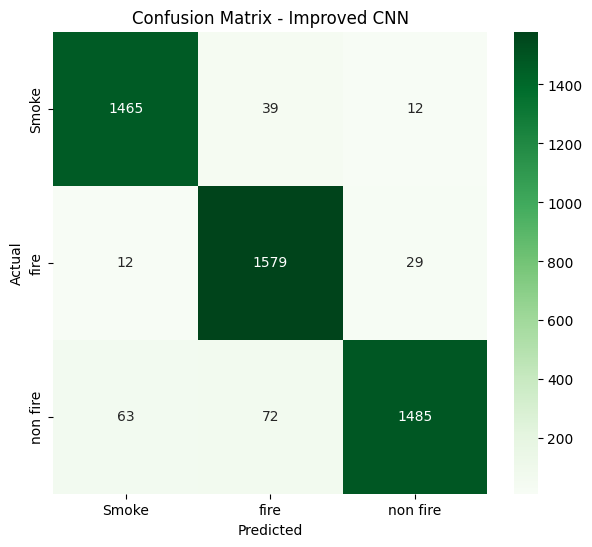

In [29]:
cm_improved = confusion_matrix(true_classes, improved_pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm_improved, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Improved CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Comparison Table

In [30]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline CNN", "Improved CNN (Augmented)"],
    "Accuracy": [baseline_acc, improved_acc],
    "Precision": [baseline_prec, improved_prec],
    "Recall": [baseline_rec, improved_rec],
    "F1-score": [baseline_f1, improved_f1]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-score
0,Baseline CNN,0.970353,0.970472,0.970353,0.970365
1,Improved CNN (Augmented),0.952271,0.952952,0.952271,0.952160


Compare Validation Curves (Baseline vs Improved)

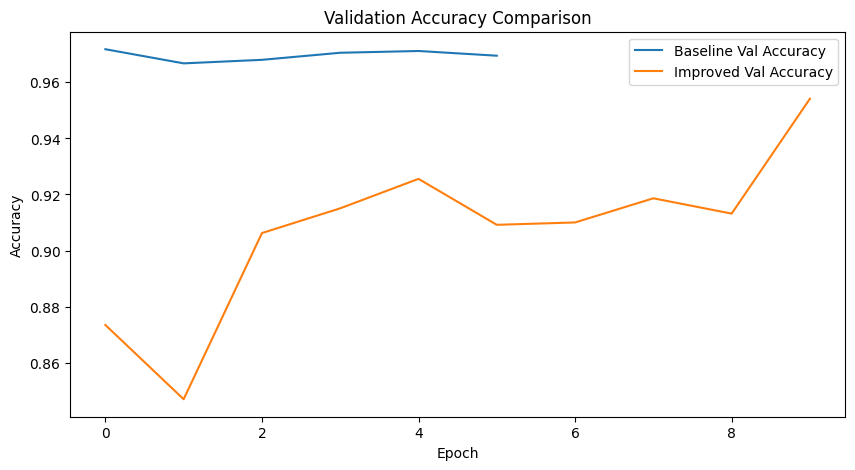

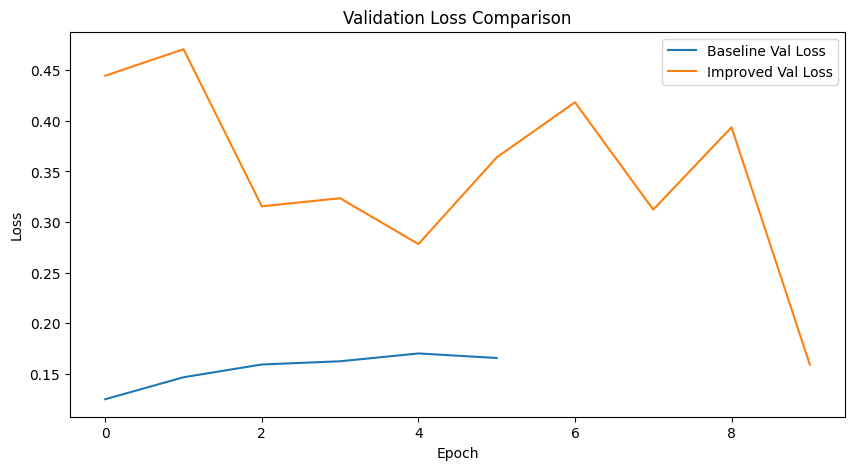

In [31]:
plt.figure(figsize=(10,5))
plt.plot(history_baseline.history["val_accuracy"], label="Baseline Val Accuracy")
plt.plot(history_improved.history["val_accuracy"], label="Improved Val Accuracy")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_baseline.history["val_loss"], label="Baseline Val Loss")
plt.plot(history_improved.history["val_loss"], label="Improved Val Loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


MISCLASSIFICATION ANALYSIS

Show Misclassified Images

Total Misclassified Images: 227


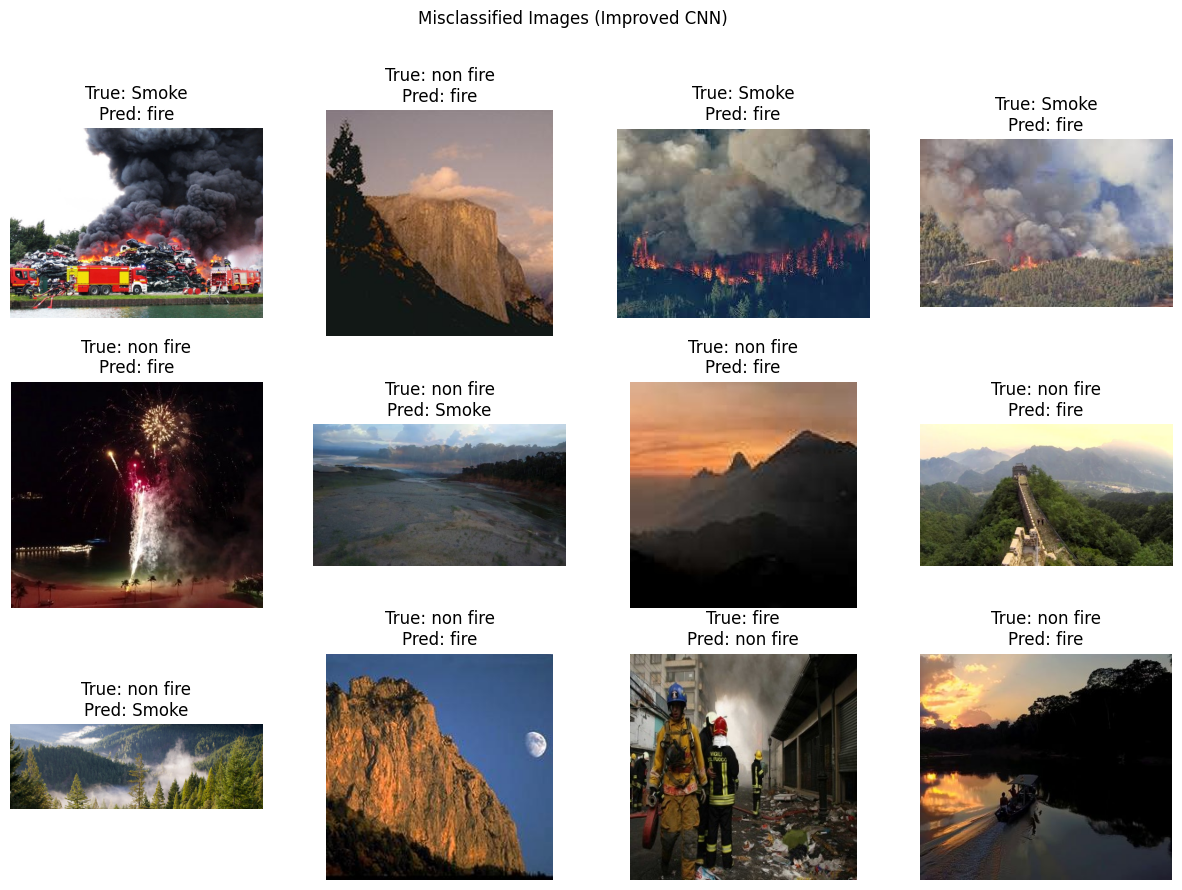

In [32]:
misclassified_idx = np.where(improved_pred_classes != true_classes)[0]
print("Total Misclassified Images:", len(misclassified_idx))

plt.figure(figsize=(15,10))

for i, idx in enumerate(misclassified_idx[:12]):
    img_path = test_df.iloc[idx]["filepath"]
    img = Image.open(img_path)

    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[improved_pred_classes[idx]]

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.suptitle("Misclassified Images (Improved CNN)")
plt.show()


Visualize Feature Maps

In [45]:
sample_path = test_df.iloc[0]["filepath"]
img = tf.keras.preprocessing.image.load_img(sample_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make a dummy call to the model to ensure its graph is built and input/output tensors are defined
# This is often needed when creating a new functional model from a Sequential model's intermediate layers
_ = improved_model(img_array)

conv_layers = [layer for layer in improved_model.layers if isinstance(layer, layers.Conv2D)]

# Create the activation model using the improved_model's inputs and the convolutional layer outputs
# Use improved_model.inputs (plural) as it returns a list of input tensors, which is expected by Model.
activation_model = models.Model(inputs=improved_model.inputs, outputs=[layer.output for layer in conv_layers])

activations = activation_model.predict(img_array)

print("Conv layers visualized:", len(activations))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Conv layers visualized: 3


Plot Feature Maps

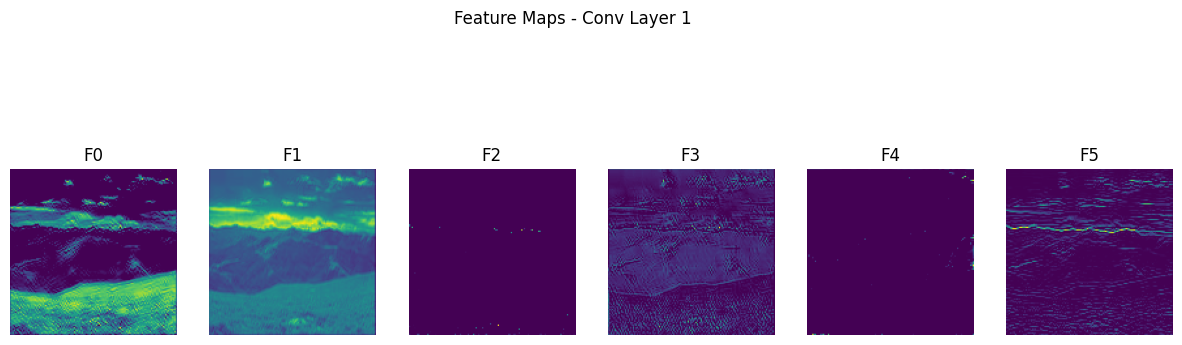

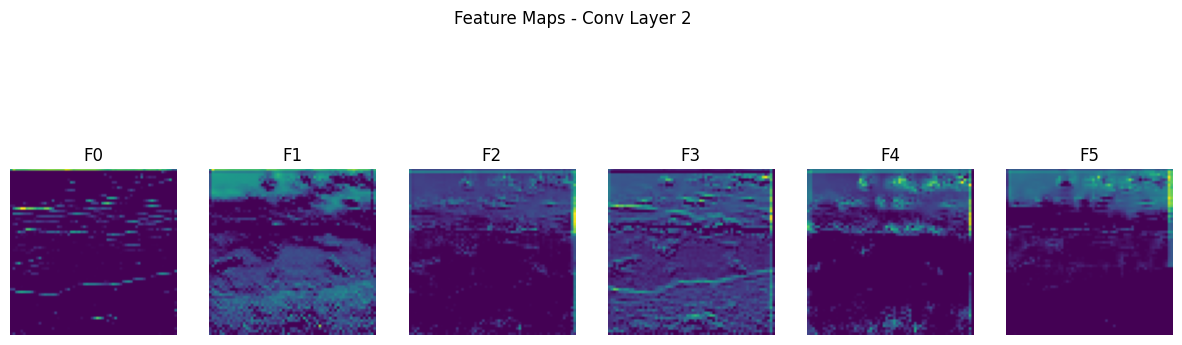

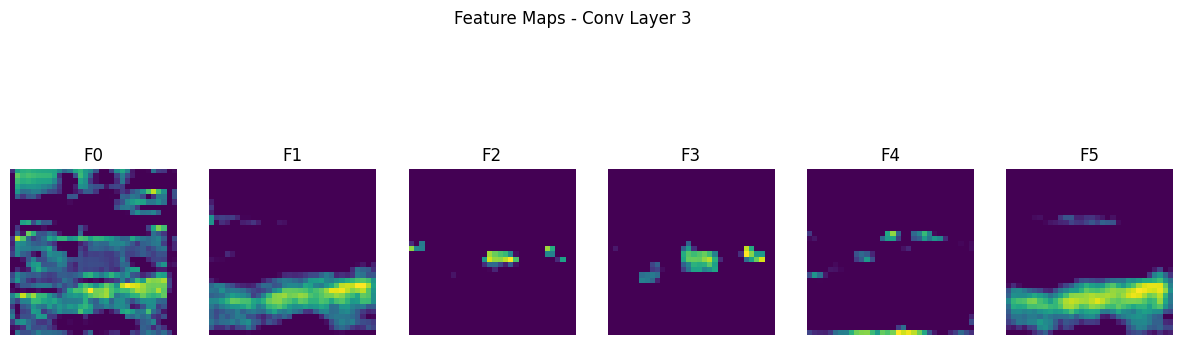

In [46]:
for layer_index, layer_activation in enumerate(activations):
    n_features = layer_activation.shape[-1]

    plt.figure(figsize=(15,5))
    for i in range(min(n_features, 6)):
        plt.subplot(1, 6, i+1)
        plt.imshow(layer_activation[0, :, :, i])
        plt.axis("off")
        plt.title(f"F{i}")

    plt.suptitle(f"Feature Maps - Conv Layer {layer_index+1}")
    plt.show()


CNN ARCHITECTURE EXPERIMENT

Alternative CNN

In [37]:
gap_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

gap_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

gap_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,147 (430.26 KB)

 Trainable params: 110,147 (430.26 KB)

 Non-trainable params: 0 (0.00 B)

Train GAP Model

In [47]:
history_gap = gap_model.fit(
    aug_train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 1165s 2s/step - accuracy: 0.7675 - loss: 0.5645 - val_accuracy: 0.8877 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 2/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.8857 - loss: 0.3226 - val_accuracy: 0.9037 - val_loss: 0.2823 - learning_rate: 0.0010
Epoch 3/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 1211s 2s/step - accuracy: 0.9151 - loss: 0.2468 - val_accuracy: 0.9315 - val_loss: 0.2216 - learning_rate: 0.0010
Epoch 4/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 1162s 2s/step - accuracy: 0.9257 - loss: 0.2183 - val_accuracy: 0.9306 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 5/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 1213s 2s/step - accuracy: 0.9317 - loss: 0.2011 - val_accuracy: 0.9445 - val_loss: 0.1969 - learning_rate: 0.0010


Evaluate GAP Model

In [48]:
test_gen.reset()
gap_preds = gap_model.predict(test_gen)
gap_pred_classes = np.argmax(gap_preds, axis=1)

gap_acc  = accuracy_score(true_classes, gap_pred_classes)
gap_prec = precision_score(true_classes, gap_pred_classes, average="weighted")
gap_rec  = recall_score(true_classes, gap_pred_classes, average="weighted")
gap_f1   = f1_score(true_classes, gap_pred_classes, average="weighted")

print("GAP Model Accuracy:", gap_acc)
print("GAP Model Precision:", gap_prec)
print("GAP Model Recall:", gap_rec)
print("GAP Model F1-score:", gap_f1)


149/149 ━━━━━━━━━━━━━━━━━━━━ 99s 665ms/step
GAP Model Accuracy: 0.9343986543313709
GAP Model Precision: 0.9354883407249448
GAP Model Recall: 0.9343986543313709
GAP Model F1-score: 0.9345705060743353


Final Comparison Table (Baseline vs Improved vs GAP)

In [49]:
final_comparison_df = pd.DataFrame({
    "Model": ["Baseline CNN", "Improved CNN", "GAP CNN (Bonus)"],
    "Accuracy": [baseline_acc, improved_acc, gap_acc],
    "Precision": [baseline_prec, improved_prec, gap_prec],
    "Recall": [baseline_rec, improved_rec, gap_rec],
    "F1-score": [baseline_f1, improved_f1, gap_f1]
})

final_comparison_df


,Model,Accuracy,Precision,Recall,F1-score
0,Baseline CNN,0.970353,0.970472,0.970353,0.970365
1,Improved CNN,0.952271,0.952952,0.952271,0.952160
2,GAP CNN (Bonus),0.934399,0.935488,0.934399,0.934571


Saving Best Model

In [50]:
improved_model.save("best_improved_cnn_model.h5")
print("Saved model: best_improved_cnn_model.h5")


Saved model: best_improved_cnn_model.h5
